## Reproducing the Educational Example (see Appendix A) of the paper PhysRevX.12.011059 by Sivak et al.

We want to implement a Reinforcement Learning (RL) model (which is a classical Neural Network) and train its agent to learn the rotation angle $\theta$ to flip the incoming quantum state $\ket{0}$ to the $\ket{1}$ state by applying a RX-gate($\theta$).

This code is implemented in ``PyTorch`` and bases its architecture on the one by Mr. Arthur Strauss who used ``TensorFlow`` (https://github.com/arthurostrauss/Quantum_Optimal_Control/tree/main/paper_results)

#### Imports

In [58]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.optim as optim

from qiskit import QuantumCircuit
from qiskit.providers.aer import QasmSimulator

#### The RL agent performs an action

To measure in the Hadamard basis (or X-basis), you can use the Hadamard gate. Specifically, before performing the measurement on a qubit prepared in a certain state, apply a Hadamard gate. This gate transforms the state from the computational (Z) basis to the Hadamard (X) basis. After applying the Hadamard gate, you can measure in the usual Z-basis, which effectively corresponds to a measurement in the X-basis.

**To measure the $\ket{+}$ state in the Hadamard basis:**

- Apply a Hadamard gate on the qubit that's in the $\ket{+}$ state.
- Measure in the computational basis ($\ket{0}$ and $\braket{0}$).
- The outcome of the measurement is then in the Hadamard basis.

**To measure the $\ket{-}$ state in the Hadamard basis:**

- Apply a z-gate on the qubit
- Apply a Hadamard gate on the qubit that's in the $\ket{-}$ state.
- Measure in the computational basis ($\ket{0}$ and $\braket{0}$).
- The outcome of the measurement is then in the Hadamard basis.

In [92]:
def perform_action(amp, shots=1, target='1'):
    """
    Execute a quantum circuit with parametrized amplitude, retrieve measurement result and assign rewards accordingly
        
        :param amp: amplitude parameter, provided as an array of size batchsize
        :param shots: number of evaluations to be done on the quantum computer
        :param target: string indicating the target state ('1' or '+')
    
        :return: Reward table (reward for each run in the batch)
    """
    global qc, qasm
    angles, batch = np.array(amp), len(np.array(amp))
    reward_table = np.zeros(batch)

    for ind, angle in enumerate(angles):
        if target == '1':
            qc.rx(2 * np.pi * angle, 0)  # Add parametrized gate for each amplitude in the batch

        elif target == '+':
            qc.ry(2 * np.pi * angle, 0)  # Add parametrized gate for each amplitude in the batch
            qc.h(0) # Transform to hadamard basis before measurement
            
        elif target == '-':
            qc.ry(2 * np.pi * angle, 0)
            qc.z(0)  # Apply Z gate for the minus state
            qc.h(0)
        
        qc.measure(0, 0)  # Measurement
        job = qasm.run(qc, shots=shots)
        result = job.result()
        counts = result.get_counts(qc)  # Returns a dict with keys '0' and '1' (possible measurement outcomes) with number of counts for each key


        #  Calculate reward
        if target == '1':
            np.mean(np.array([1] * counts.get('1', 0) + [-1] * counts.get('0', 0)))
        elif target in ['+', '-']:
            reward_table[ind] += np.mean(np.array([1] * counts.get('0', 0) + [-1] * counts.get('1', 0)))

        qc.clear()

    return reward_table

#### Set Hyperparameters for the RL

In [93]:
# Variables to define environment
qc = QuantumCircuit(1, 1)  # Two-level system of interest, 1 qubit
qasm = QasmSimulator()  # Simulation backend (mock quantum computer)

seed = 2364

# Hyperparameters for the agent
n_epochs = 100
batch_size = 50
eta = 0.01  # Learning rate for policy update step

# Policy parameters
mu = nn.Parameter(torch.randn([]) * 0.05)  # Initializing mu with a value drawn from a normal distribution with mean 0, sigma 0.05
sigma = nn.Parameter(torch.tensor(0.05))  # Initializing sigma with a value of 0.05

# Critic parameter (single state-independent baseline b)
b = nn.Parameter(torch.tensor(0.))

#### Training

In [96]:
# Create an optimizer for the trainable parameters
optimizer = optim.Adam([mu, sigma, b], lr=eta)
epsilon = 1e-3 # Small offset to avoid sigma = 0
 # Clip the gradients
grad_clip = 0.3

def constrain_mu(value, min_val, max_val):
    return torch.clamp(value, min_val, max_val)

def constrain_sigma(value):
    return torch.relu(value) # Ensures that sigma is non-negative

# Dictionary to keep track of the used parameters
params = {
            'mu': [],
            'sigma': [],
            'reward': [],
            'learning_rate': eta,
            'seed': seed,
            'batch_size': batch_size,
            'n_epochs': n_epochs,
}

### Training loop
for i in tqdm(range(n_epochs)):
    print('\nEPOCH', i+1)
    print('Policy parameter')
    print(f'mu = {mu.item()} +- sigma = {sigma.item()}')
    print('baseline', b.item())

    # Sample action from policy (Gaussian distribution with parameters mu and sigma)
    Normal_distrib = Normal(loc=mu, scale=sigma + epsilon)
    action = Normal_distrib.sample((batch_size,)) # action 

    # Run quantum circuit to retrieve rewards (in this example, only one time step)
    reward = perform_action(action, shots=1, target='-')
    #reward = perform_action(action, shots=1)
    print("Average Return:", reward.mean().item())

    advantage = torch.tensor(reward, dtype=torch.float32) - b
    
    log_probs = Normal_distrib.log_prob(action)

    actor_loss = -(advantage * log_probs).mean()
    critic_loss = (advantage ** 2).mean()
    critic_loss_coeff = 0.5
    combined_loss = actor_loss + critic_loss_coeff * critic_loss

    # Clear previous gradients
    optimizer.zero_grad() 
    # Backpropagation
    combined_loss.backward()
    # Clip the gradients
    torch.nn.utils.clip_grad_norm_([mu, sigma, b], grad_clip)
    # Apply gradients
    optimizer.step()

    # During training, after each optimizer step:
    with torch.no_grad():
        mu.data = constrain_mu(mu.data, -2., 2.)
        sigma.data = constrain_sigma(sigma.data)
  
    params["mu"].append(mu.item())
    params["sigma"].append(sigma.item())
    params["reward"].append(reward)

  6%|▌         | 6/100 [00:00<00:01, 57.39it/s]


EPOCH 1
Policy parameter
mu = -0.33400222659111023 +- sigma = 0.0012032458325847983
baseline -0.6745163202285767
Average Return: 0.8

EPOCH 2
Policy parameter
mu = -0.3240022361278534 +- sigma = 0.0
baseline -0.6845163106918335
Average Return: 0.96

EPOCH 3
Policy parameter
mu = -0.31556516885757446 +- sigma = 0.0
baseline -0.694430947303772
Average Return: 0.72

EPOCH 4
Policy parameter
mu = -0.30670610070228577 +- sigma = 0.0
baseline -0.7041622400283813
Average Return: 0.96

EPOCH 5
Policy parameter
mu = -0.30426880717277527 +- sigma = 0.0014045076677575707
baseline -0.7133278250694275
Average Return: 0.96

EPOCH 6
Policy parameter
mu = -0.30174437165260315 +- sigma = 0.00554701080545783
baseline -0.7227318286895752
Average Return: 0.92

EPOCH 7
Policy parameter
mu = -0.30291947722435 +- sigma = 0.008897539228200912
baseline -0.7323240637779236
Average Return: 1.0

EPOCH 8
Policy parameter
mu = -0.30436429381370544 +- sigma = 0.008884711191058159
baseline -0.7420739531517029
Averag

 20%|██        | 20/100 [00:00<00:01, 64.53it/s]

Average Return: 0.84

EPOCH 14
Policy parameter
mu = -0.29559099674224854 +- sigma = 0.013029087334871292
baseline -0.7946438193321228
Average Return: 0.92

EPOCH 15
Policy parameter
mu = -0.2944299578666687 +- sigma = 0.013857761397957802
baseline -0.8015494346618652
Average Return: 0.96

EPOCH 16
Policy parameter
mu = -0.29228970408439636 +- sigma = 0.015948396176099777
baseline -0.8080067038536072
Average Return: 0.96

EPOCH 17
Policy parameter
mu = -0.28889787197113037 +- sigma = 0.016954975202679634
baseline -0.8143295645713806
Average Return: 1.0

EPOCH 18
Policy parameter
mu = -0.28551968932151794 +- sigma = 0.016235610470175743
baseline -0.8206499218940735
Average Return: 1.0

EPOCH 19
Policy parameter
mu = -0.2809676229953766 +- sigma = 0.01602407544851303
baseline -0.827084481716156
Average Return: 0.96

EPOCH 20
Policy parameter
mu = -0.2755211889743805 +- sigma = 0.01513239648193121
baseline -0.8336082696914673
Average Return: 1.0

EPOCH 21
Policy parameter
mu = -0.26926767

 34%|███▍      | 34/100 [00:00<00:01, 65.97it/s]

Average Return: 0.92

EPOCH 28
Policy parameter
mu = -0.23093409836292267 +- sigma = 0.00790887139737606
baseline -0.8851174712181091
Average Return: 1.0

EPOCH 29
Policy parameter
mu = -0.22829045355319977 +- sigma = 0.0035789022222161293
baseline -0.8913151621818542
Average Return: 1.0

EPOCH 30
Policy parameter
mu = -0.2246474325656891 +- sigma = 0.0
baseline -0.8973383903503418
Average Return: 1.0

EPOCH 31
Policy parameter
mu = -0.2212526500225067 +- sigma = 0.0
baseline -0.9029179811477661
Average Return: 0.96

EPOCH 32
Policy parameter
mu = -0.21761231124401093 +- sigma = 0.0
baseline -0.9081867337226868
Average Return: 1.0

EPOCH 33
Policy parameter
mu = -0.21493388712406158 +- sigma = 0.0
baseline -0.9130430817604065
Average Return: 1.0

EPOCH 34
Policy parameter
mu = -0.21138978004455566 +- sigma = 0.0
baseline -0.9178648591041565
Average Return: 1.0

EPOCH 35
Policy parameter
mu = -0.2071230113506317 +- sigma = 0.0
baseline -0.9223944544792175
Average Return: 0.96

EPOCH 36


 49%|████▉     | 49/100 [00:00<00:00, 67.32it/s]

Average Return: 0.96

EPOCH 42
Policy parameter
mu = -0.19481034576892853 +- sigma = 0.0
baseline -0.9581853151321411
Average Return: 0.96

EPOCH 43
Policy parameter
mu = -0.19444482028484344 +- sigma = 0.0
baseline -0.9628297090530396
Average Return: 0.8

EPOCH 44
Policy parameter
mu = -0.19282163679599762 +- sigma = 0.0
baseline -0.9671943187713623
Average Return: 0.84

EPOCH 45
Policy parameter
mu = -0.1922142505645752 +- sigma = 0.0
baseline -0.971257746219635
Average Return: 0.96

EPOCH 46
Policy parameter
mu = -0.19092006981372833 +- sigma = 0.0
baseline -0.9752641320228577
Average Return: 1.0

EPOCH 47
Policy parameter
mu = -0.19119009375572205 +- sigma = 0.0
baseline -0.9791038036346436
Average Return: 0.88

EPOCH 48
Policy parameter
mu = -0.19242461025714874 +- sigma = 0.0
baseline -0.9827814102172852
Average Return: 0.96

EPOCH 49
Policy parameter
mu = -0.19339542090892792 +- sigma = 0.0
baseline -0.9863114356994629
Average Return: 1.0

EPOCH 50
Policy parameter
mu = -0.19326

 63%|██████▎   | 63/100 [00:00<00:00, 67.34it/s]

Average Return: 0.96

EPOCH 56
Policy parameter
mu = -0.19171473383903503 +- sigma = 0.009125100448727608
baseline -1.0086710453033447
Average Return: 0.92

EPOCH 57
Policy parameter
mu = -0.19041211903095245 +- sigma = 0.011580267921090126
baseline -1.0126358270645142
Average Return: 0.92

EPOCH 58
Policy parameter
mu = -0.18981346487998962 +- sigma = 0.01254956517368555
baseline -1.0166893005371094
Average Return: 0.96

EPOCH 59
Policy parameter
mu = -0.1898982673883438 +- sigma = 0.012209375388920307
baseline -1.0206236839294434
Average Return: 1.0

EPOCH 60
Policy parameter
mu = -0.18960338830947876 +- sigma = 0.010629062540829182
baseline -1.024981141090393
Average Return: 0.88

EPOCH 61
Policy parameter
mu = -0.19007502496242523 +- sigma = 0.008057234808802605
baseline -1.029631495475769
Average Return: 1.0

EPOCH 62
Policy parameter
mu = -0.19007812440395355 +- sigma = 0.004498572088778019
baseline -1.0342819690704346
Average Return: 1.0

EPOCH 63
Policy parameter
mu = -0.189670

 77%|███████▋  | 77/100 [00:01<00:00, 67.44it/s]

Average Return: 0.92

EPOCH 70
Policy parameter
mu = -0.18961326777935028 +- sigma = 0.0
baseline -1.0711827278137207
Average Return: 0.96

EPOCH 71
Policy parameter
mu = -0.1912137269973755 +- sigma = 0.0
baseline -1.075011968612671
Average Return: 0.88

EPOCH 72
Policy parameter
mu = -0.19186444580554962 +- sigma = 0.0
baseline -1.0788041353225708
Average Return: 1.0

EPOCH 73
Policy parameter
mu = -0.191055566072464 +- sigma = 0.0
baseline -1.0825506448745728
Average Return: 0.96

EPOCH 74
Policy parameter
mu = -0.19104647636413574 +- sigma = 0.0
baseline -1.0866491794586182
Average Return: 0.84

EPOCH 75
Policy parameter
mu = -0.1925811618566513 +- sigma = 0.0
baseline -1.0906703472137451
Average Return: 0.92

EPOCH 76
Policy parameter
mu = -0.19278040528297424 +- sigma = 0.0
baseline -1.0944240093231201
Average Return: 0.96

EPOCH 77
Policy parameter
mu = -0.19388797879219055 +- sigma = 0.0
baseline -1.0980510711669922
Average Return: 0.92

EPOCH 78
Policy parameter
mu = -0.194525

 91%|█████████ | 91/100 [00:01<00:00, 67.41it/s]

Average Return: 1.0

EPOCH 84
Policy parameter
mu = -0.19556377828121185 +- sigma = 0.0
baseline -1.1193262338638306
Average Return: 0.96

EPOCH 85
Policy parameter
mu = -0.19702467322349548 +- sigma = 0.0
baseline -1.1217844486236572
Average Return: 1.0

EPOCH 86
Policy parameter
mu = -0.19809626042842865 +- sigma = 0.0
baseline -1.124083399772644
Average Return: 0.92

EPOCH 87
Policy parameter
mu = -0.20059335231781006 +- sigma = 0.0
baseline -1.1263631582260132
Average Return: 1.0

EPOCH 88
Policy parameter
mu = -0.2024753838777542 +- sigma = 0.0
baseline -1.130091905593872
Average Return: 1.0

EPOCH 89
Policy parameter
mu = -0.20451170206069946 +- sigma = 0.0
baseline -1.133582592010498
Average Return: 0.96

EPOCH 90
Policy parameter
mu = -0.20761772990226746 +- sigma = 0.0
baseline -1.1369225978851318
Average Return: 1.0

EPOCH 91
Policy parameter
mu = -0.21177753806114197 +- sigma = 0.0
baseline -1.1400855779647827
Average Return: 1.0

EPOCH 92
Policy parameter
mu = -0.2140672057

100%|██████████| 100/100 [00:01<00:00, 66.71it/s]

Average Return: 1.0

EPOCH 98
Policy parameter
mu = -0.23739217221736908 +- sigma = 0.0058886404149234295
baseline -1.1598650217056274
Average Return: 1.0

EPOCH 99
Policy parameter
mu = -0.24295097589492798 +- sigma = 0.0059143779799342155
baseline -1.163053274154663
Average Return: 1.0

EPOCH 100
Policy parameter
mu = -0.24907800555229187 +- sigma = 0.005032624118030071
baseline -1.1666477918624878
Average Return: 1.0


#### Visualization

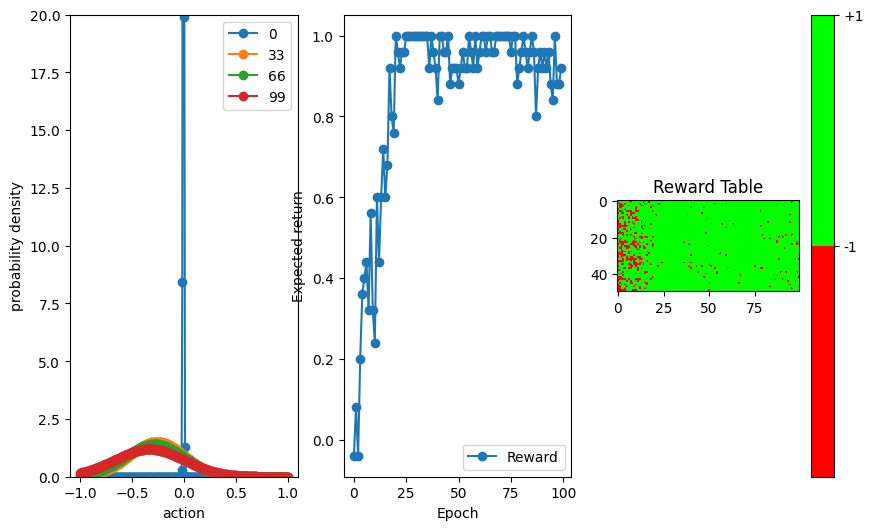

In [95]:
x = np.linspace(-1., 1., 300)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))
# Plot probability density associated to updated parameters for a few steps
for i in np.linspace(0, n_epochs-1, n_epochs//25, dtype=int):
    ax1.plot(x, norm.pdf(x, loc=params["mu"][i], scale=np.abs(params["mu"][i])), '-o', label=f'{i}')

ax1.set_xlabel("action")
ax1.set_ylabel("probability density")
ax1.set_ylim(0., 20)
#  Plot return as a function of epochs
ax2.plot(np.mean(params["reward"], axis=1), '-o', label='Reward')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Expected return")
ax2.legend()
ax1.legend()

rewards = np.array(params['reward']).transpose()
# Create a custom colormap
colors = [(1, 0, 0), (0, 1, 0)]  # R -> G
cmap_name = 'custom_red_green'
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=2)

# Dummy data and imshow for ax3
cax = ax3.imshow(rewards, cmap=cm)
ax3.set_title("Reward Table")

# Add colorbar to ax3
cbar = fig.colorbar(cax, ax=ax3, ticks=[0, 1])
cbar.ax.set_yticklabels(['-1', '+1'])

plt.show()